# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Features](#Features)
- [Random Forest](#Random-Forest-Regression-Model)
    - [Fastball RHP](#Fastball-RHP)
    - [Fastball LHP](#Fastball-LHP)
    - [Breaking Ball RHP](#Breaking-Ball-RHP)
    - [BreakingBall LHP](#Breaking-Ball-LHP)
    - [Off Speed RHP](#Off-Speed-RHP)
    - [Off Speed LHP](#Off-Speed-LHP)

# Imports

In [1]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv2022.csv', index_col = [0])
pd.set_option('max_columns', None)
#data.dropna(inplace = True)
print(data.shape)
data.head()

(682572, 65)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_x,plate_z,type,balls,strikes,pitch_count,stand,bb_type,description,events,hit_distance_sc,exit_velo,launch_angle,woba_value,woba_denom,xwoba,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,pitch_type2,arm_angle,slot,whiff,is_strike,is_ball,final_pitch_ab,out_to_end_inning,home_runs,away_runs,runs,re,re_change,re_end_state,re24,lin_weight_above_avg,lin_weight_rel_outs,woba_scale,lin_weights_above_avg_scale,lin_weights_rel_outs_scale,woba,wraa_change,rv
0,"Zastryzny, Rob",L,FF,93.5,2451.0,167.0,-3.36,17.40,26.213904,94.6,-1.70,5.95,6.6,53.88,0.76,3.38,S,2,2,2-2,L,NaN,strike,field_out,NaN,NaN,NaN,0.0,1.0,NaN,78.0,6.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,1,0,1,1,0.0,0.0,0.0,0.11,-0.11,0.00,-0.11,-0.27,0.001,1.209,-0.326,0.001,0.269,-0.184,-0.110
1,"Zastryzny, Rob",L,CU,80.9,2266.0,273.0,13.44,-0.96,28.009889,81.1,-2.06,5.59,6.5,53.95,0.66,0.49,B,1,2,1-2,L,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,5.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,CU,35.2,1,0,0,1,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.222,0.032,0.032
2,"Zastryzny, Rob",L,FF,92.3,2321.0,157.0,-3.36,18.96,25.146262,92.8,-1.65,5.93,6.7,53.84,0.20,3.12,S,1,2,1-2,L,NaN,strike,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,4.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,1,0,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.222,-0.152,-0.152
3,"Zastryzny, Rob",L,FF,94.3,2391.0,159.0,-4.80,17.28,25.355249,94.4,-1.65,5.93,6.4,54.09,-0.53,3.69,B,0,2,0-2,L,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,3.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,0,1,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.197,0.017,0.017
4,"Zastryzny, Rob",L,FF,93.4,2446.0,156.0,-3.60,18.00,26.188437,93.3,-1.81,5.93,6.4,54.13,0.62,2.19,S,0,1,0-1,L,NaN,strike,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,2.0,9,0,8.0,3.0,8.0,3.0,0,0,0,2,FF,32.4,1,0,1,0,0,0,0.0,0.0,0.0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.000,0.265,-0.047,-0.047


In [3]:
data.whiff.mean()

0.11404364667756661

# Features

**Independent Variables:** Velocity, HB, VB, Release Side, Release Height, Release Extension

**Dependent Variable:** Whiff

### Multicolinearity - VIF

In [4]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'pfx_x', 'pfx_z', 
                 'release_pos_x', 'release_pos_z', 'release_extension', 'whiff']]

#features_vif = features.select_dtypes([np.number])
#vif_data = pd.DataFrame()
#vif_data["feature"] = features_vif.columns
#
#vif_data["VIF"] = [variance_inflation_factor(features_vif.values, i)
#                   for i in range(len(features_vif.columns))]
#
#print(vif_data.sort_values(by = 'VIF'))

In [5]:
fb = features[features['pitch_type'].isin(['FF', 'SI'])]
bb = features[features['pitch_type'].isin(['SL', 'FC', 'CU', 'KC'])]
os = features[features['pitch_type'].isin(['CH', 'FS'])]
rhp = features.loc[features['p_throws'] == 'R']
lhp = features.loc[features['p_throws'] == 'L']
rhp_fb = fb.loc[fb['p_throws'] == 'R']
lhp_fb = fb.loc[fb['p_throws'] == 'L']
rhp_bb = bb.loc[bb['p_throws'] == 'R']
lhp_bb = bb.loc[bb['p_throws'] == 'L']
rhp_os = os.loc[os['p_throws'] == 'R']
lhp_os = os.loc[os['p_throws'] == 'L']

# Random Forest Regression Model

## Fastball RHP Grouped

#### 4-Seam, Sinker

In [6]:
print('Baseline RHP Fastball Whiff% Accuracy Score:', round(rhp_fb.whiff.mean(), 2))

Baseline RHP Fastball Whiff% Accuracy Score: 0.08


In [7]:
features_fb_r = rhp_fb.select_dtypes([np.number])
X = features_fb_r.drop(columns = ['whiff'])
y = features_fb_r['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_fb_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_fb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fb_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fb_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.035
Test RMSE: 0.278
Test MAE: 0.165 

R2 Score: 0.639
RMSE: 0.165
MAE: 0.087


- Average RHP FB Whiff% prediction error is 27.8%

### RHP Fastball Actual & Predicted Values

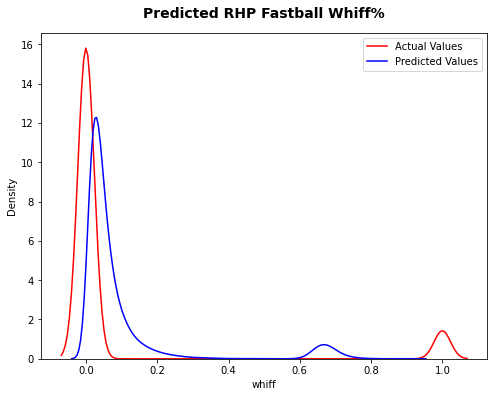

In [8]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Fastball Whiff%', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Fastball Stuff+ Table

In [9]:
rhp_fb['xWhiff'] = pred * 100
rhp_fb['n_pitches'] = 1
rhp_fb['Stuff+'] = 100 * (rhp_fb['xWhiff'] / rhp_fb['xWhiff'].mean())
#rhp_fb.head()

grouped_fb_r = rhp_fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches'].sum()

avg_fb_r = rhp_fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension', 'Stuff+'].mean()
fbr_stuff = pd.merge(avg_fb_r, grouped_fb_r, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
fbr_stuff = fbr_stuff.loc[fbr_stuff['n_pitches'] >= 100]
fbr_stuff = fbr_stuff.round(1)
fbr_stuff.insert(3, 'n_pitches', fbr_stuff.pop('n_pitches'))
fbr_stuff.sort_values(by = 'Stuff+', ascending = False).head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,Stuff+
603,"O'Day, Darren",R,FF,160,86.0,11.3,9.9,2.7,3.7,6.7,216.8
217,"Domínguez, Seranthony",R,FF,295,97.6,3.1,14.0,2.2,5.5,6.2,198.2
233,"Díaz, Edwin",R,FF,378,99.1,13.4,13.5,2.3,4.8,7.3,197.0
252,"Fairbanks, Pete",R,FF,216,99.0,0.1,20.7,0.3,7.0,6.6,191.3
139,"Castillo, Luis",R,FF,802,97.1,11.3,13.7,2.8,5.3,5.6,187.2
292,"García, Yimi",R,FF,444,94.9,9.4,13.8,2.6,5.0,5.8,182.4
613,"Ort, Kaleb",R,FF,302,96.2,9.4,16.7,2.9,5.6,6.1,181.8
734,"Sewald, Paul",R,FF,487,92.5,11.9,13.7,3.7,4.4,6.5,179.7
568,"Montero, Rafael",R,FF,464,96.4,9.3,15.9,1.4,5.2,6.1,177.2
106,"Brogdon, Connor",R,FF,224,95.1,10.8,16.5,2.6,5.9,7.0,177.0


Velocity, Spin Rate, HB, VB, Release Side, Release Height, Release Extension

### RHP Fastball Stuff+ Movement Plot

RHP Fastball Avg Stuff+: 100


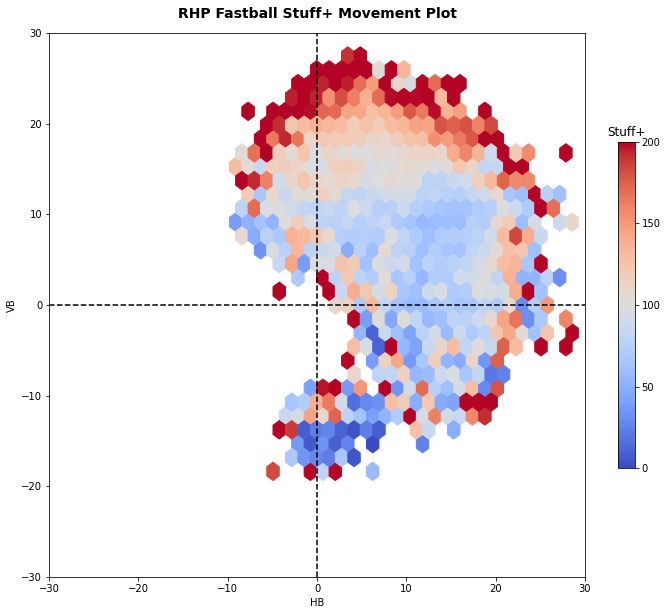

In [10]:
plt.figure(figsize = (12, 10))

plt.hexbin(rhp_fb['pfx_x'], rhp_fb['pfx_z'], C = rhp_fb['Stuff+'], cmap = 'coolwarm', 
           mincnt = 0, gridsize = 30)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Fastball Avg Stuff+:', round(rhp_fb['Stuff+'].mean()))

## Fastball LHP Grouped

#### 4-Seam, Sinker

In [11]:
print('Baseline LHP Fastball Whiff% Accuracy Score:', round(lhp_fb.whiff.mean(), 2))

Baseline LHP Fastball Whiff% Accuracy Score: 0.08


In [12]:
features_fb_l = lhp_fb.select_dtypes([np.number])
X = features_fb_l.drop(columns = ['whiff'])
y = features_fb_l['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_fb_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_fb_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fb_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fb_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.04
Test RMSE: 0.288
Test MAE: 0.169 

R2 Score: 0.628
RMSE: 0.17
MAE: 0.088


- Average LHP FB Run Value prediction error is .26 runs

### LHP Fastball Actual & Predicted Values

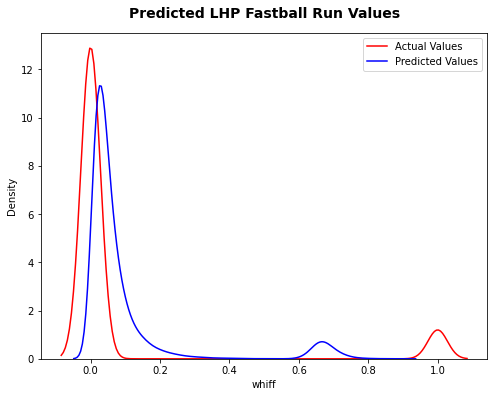

In [13]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Fastball Run Values', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball Stuff+ Table

In [14]:
lhp_fb['xWhiff'] = pred * 100
lhp_fb['n_pitches'] = 1
lhp_fb['Stuff+'] = 100 * (lhp_fb['xWhiff'] / lhp_fb['xWhiff'].mean())
#lhp_fb.head()

grouped_fb_l = lhp_fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches'].sum()

avg_fb_l = lhp_fb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension', 'Stuff+'].mean()
fbl_stuff = pd.merge(avg_fb_l, grouped_fb_l, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
fbl_stuff = fbl_stuff.loc[fbl_stuff['n_pitches'] >= 100]
fbl_stuff = fbl_stuff.round(1)
fbl_stuff.insert(3, 'n_pitches', fbl_stuff.pop('n_pitches'))
fbl_stuff.sort_values(by = 'Stuff+', ascending = False).head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,Stuff+
118,"Hernández, Darwinzon",L,FF,102,94.3,-3.0,13.4,-2.8,4.8,6.8,208.4
228,"Quijada, José",L,FF,559,94.5,-5.9,15.5,-2.3,5.4,6.6,173.5
69,"Detwiler, Ross",L,FF,116,92.4,-8.8,17.1,-1.5,6.6,5.5,170.4
107,"Hader, Josh",L,SI,642,97.4,-8.5,17.6,-2.8,5.5,6.8,167.3
117,"Hentges, Sam",L,SI,238,95.7,-14.1,10.3,-1.9,6.4,6.7,167.0
108,"Hall, DL",L,FF,129,96.3,-6.7,16.9,-3.1,5.6,6.8,165.5
74,"Diekman, Jake",L,FF,503,95.6,-15.8,12.6,-3.4,5.5,6.4,162.9
308,"Vesia, Alex",L,FF,568,94.2,-5.0,19.5,-0.9,5.8,6.5,162.3
301,"Thielbar, Caleb",L,FF,484,92.8,-3.2,19.4,-0.3,6.1,6.3,161.3
111,"Heaney, Andrew",L,FF,731,92.9,-14.8,14.3,-2.9,5.1,6.2,158.1


### LHP Fastball Stuff+ Movement Plot

LHP Fastball Avg Stuff+: 100


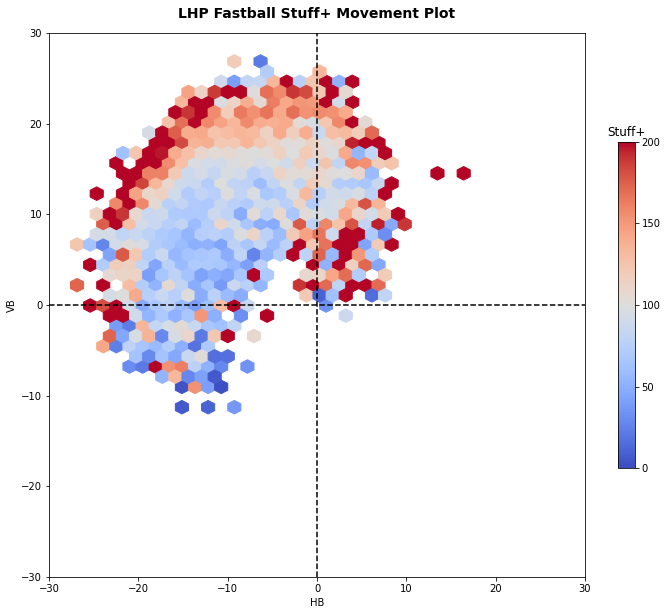

In [15]:
plt.figure(figsize = (12, 10))

plt.hexbin(lhp_fb['pfx_x'], lhp_fb['pfx_z'], C = lhp_fb['Stuff+'], cmap = 'coolwarm', 
           mincnt = 0, gridsize = 30)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Fastball Avg Stuff+:', round(lhp_fb['Stuff+'].mean()))

## Breaking Ball RHP

#### Cutter, Slider, Curveball

In [16]:
print('Baseline RHP Breaking Ball Whiff% Accuracy Score:', round(rhp_bb.whiff.mean(), 2))

Baseline RHP Breaking Ball Whiff% Accuracy Score: 0.14


In [17]:
features_bb_r = rhp_bb.select_dtypes([np.number])
X = features_bb_r.drop(columns = ['whiff'])
y = features_bb_r['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_bb_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_bb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.03
Test RMSE: 0.351
MAE: 0.252 

R2 Score: 0.639
Test RMSE: 0.208
MAE: 0.133


- Average RHP Breaking Ball Run Value prediction error is .26 runs

### RHP Breaking Ball Actual & Predicted Values

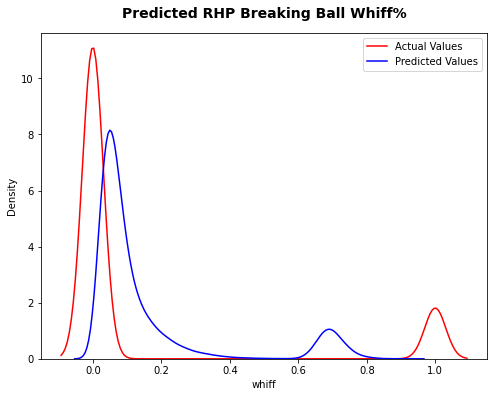

In [18]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Breaking Ball Whiff%', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Breaking Ball Stuff+ Table

In [19]:
rhp_bb['xWhiff'] = pred * 100
rhp_bb['n_pitches'] = 1
rhp_bb['Stuff+'] = 100 * (rhp_bb['xWhiff'] / rhp_bb['xWhiff'].mean())
#rhp_bb.head()

grouped_bb_r = rhp_bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches'].sum()

avg_bb_r = rhp_bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension', 'Stuff+'].mean()
bbr_stuff = pd.merge(avg_bb_r, grouped_bb_r, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
bbr_stuff = bbr_stuff.loc[bbr_stuff['n_pitches'] >= 100]
bbr_stuff = bbr_stuff.round(1)
bbr_stuff.insert(3, 'n_pitches', bbr_stuff.pop('n_pitches'))
bbr_stuff.sort_values(by = 'Stuff+', ascending = False).head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,Stuff+
242,"Díaz, Edwin",R,SL,514,90.8,-1.5,4.3,2.2,5.1,7.1,202.7
988,"deGrom, Jacob",R,SL,369,92.6,-3.6,5.2,1.5,5.6,6.6,191.8
382,"Helsley, Ryan",R,SL,293,89.2,-4.6,2.2,0.5,6.0,6.7,189.7
162,"Clase, Emmanuel",R,SL,340,91.9,-7.1,-0.2,0.7,6.1,6.5,183.7
725,"Pressly, Ryan",R,SL,239,89.7,-5.1,2.8,0.3,6.1,6.1,182.2
518,"Leone, Dominic",R,SL,285,85.1,-5.1,-2.9,2.3,5.9,6.6,182.0
504,"Lange, Alex",R,CU,497,85.5,-0.7,-5.5,2.6,5.7,6.4,179.8
731,"Rainey, Tanner",R,SL,142,88.3,-3.6,1.7,2.9,6.1,6.4,176.8
118,"Burnes, Corbin",R,SL,295,88.2,-7.4,-0.1,0.6,5.9,6.4,175.2
241,"Díaz, Alexis",R,SL,331,86.8,-5.8,0.8,1.9,4.9,7.5,174.6


### RHP Breaking Ball Stuff+ Movement Plot

RHP Breaking Ball Avg Stuff+: 100


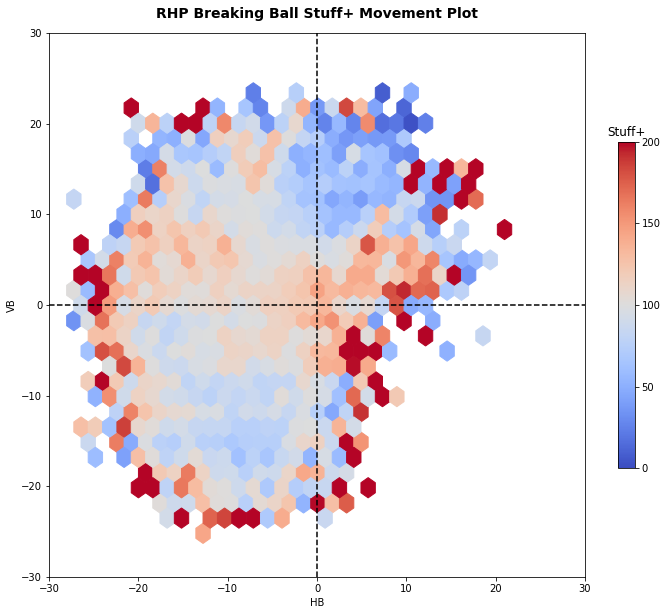

In [20]:
plt.figure(figsize = (12, 10))

plt.hexbin(rhp_bb['pfx_x'], rhp_bb['pfx_z'], C = rhp_bb['Stuff+'], cmap = 'coolwarm', 
           mincnt = 0, gridsize = 30)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Breaking Ball Avg Stuff+:', round(rhp_bb['Stuff+'].mean()))

## Breaking Ball LHP
#### Slider, Cutter, Curveball, Knuckle Curve

In [21]:
print('Baseline LHP Breaking Ball Whiff% Accuracy Score:', round(lhp_bb.whiff.mean(), 2))

Baseline LHP Breaking Ball Whiff% Accuracy Score: 0.14


In [22]:
features_bb_l = lhp_bb.select_dtypes([np.number])
X = features_bb_l.drop(columns = ['whiff'])
y = features_bb_l['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_bb_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_bb_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.038
Test RMSE: 0.353
Test MAE: 0.252 

R2 Score: 0.637
RMSE: 0.21
MAE: 0.133


- Average LHP Breaking Ball Whiff prediction error is 35.3%

### LHP Breaking Ball Actual & Predicted Values

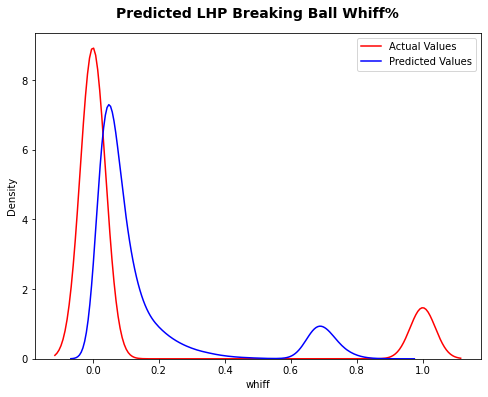

In [23]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Breaking Ball Whiff%', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Breaking Ball Stuff+ Table

In [24]:
lhp_bb['xWhiff'] = pred * 100
lhp_bb['n_pitches'] = 1
lhp_bb['Stuff+'] = 100 * (lhp_bb['xWhiff'] / lhp_bb['xWhiff'].mean())
#lhp_bb.head()

grouped_bb_l = lhp_bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches'].sum()

avg_bb_l = lhp_bb.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension', 'Stuff+'].mean()
bbl_stuff = pd.merge(avg_bb_l, grouped_bb_l, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
bbl_stuff = bbl_stuff.loc[bbl_stuff['n_pitches'] >= 100]
bbl_stuff = bbl_stuff.round(1)
bbl_stuff.insert(3, 'n_pitches', bbl_stuff.pop('n_pitches'))
bbl_stuff.sort_values(by = 'Stuff+', ascending = False).head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,Stuff+
50,"Chafin, Andrew",L,SL,275,82.9,0.3,-0.6,-1.9,6.2,6.5,194.4
12,"Alvarado, José",L,FC,372,93.8,1.9,5.6,-1.2,6.5,6.7,186.7
153,"Lee, Dylan",L,SL,358,83.8,3.2,4.4,-1.7,6.4,6.5,180.6
186,"McClanahan, Shane",L,SL,380,89.3,3.6,3.7,-1.1,6.1,6.8,170.2
292,"Snell, Blake",L,SL,560,88.9,4.1,4.7,-2.1,6.6,6.7,169.8
114,"Heaney, Andrew",L,SL,380,83.3,3.7,1.3,-3.0,5.2,5.9,165.5
230,"Peterson, David",L,SL,539,84.4,3.9,1.1,-2.2,5.8,7.0,164.1
287,"Smith, Will",L,SL,454,81.7,4.9,2.6,-1.7,6.4,6.1,156.7
110,"Hader, Josh",L,SL,264,84.0,4.1,0.7,-3.2,5.2,6.7,152.9
218,"Nardi, Andrew",L,SL,107,84.0,12.3,5.2,-2.9,5.8,6.8,152.9


### LHP Breaking Ball Stuff+ Movement Plot

LHP Breaking Ball Avg Stuff+: 100


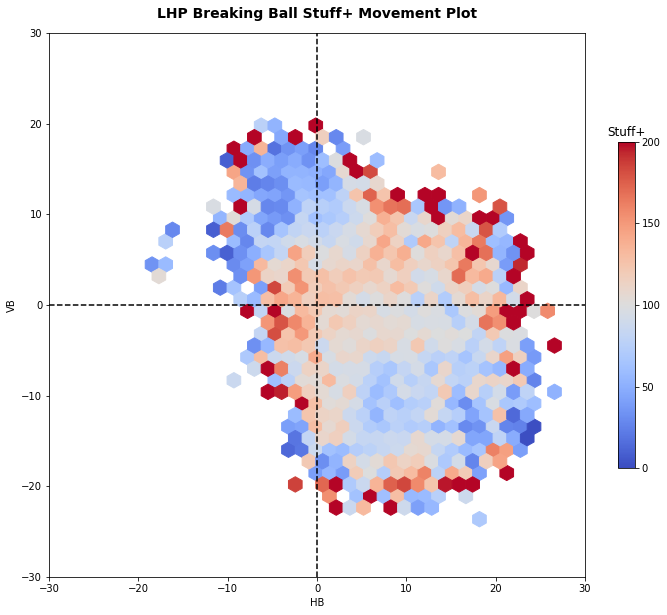

In [25]:
plt.figure(figsize = (12, 10))

plt.hexbin(lhp_bb['pfx_x'], lhp_bb['pfx_z'], C = lhp_bb['Stuff+'], cmap = 'coolwarm', 
           mincnt = 0, gridsize = 30)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Breaking Ball Avg Stuff+:', round(lhp_bb['Stuff+'].mean()))

## Off Speed RHP

#### Changeup, Splitter

In [26]:
print('Baseline RHP Off Speed Whiff% Accuracy Score:', round(rhp_os.whiff.mean(), 2))

Baseline RHP Off Speed Whiff% Accuracy Score: 0.15


In [27]:
features_os_r = rhp_os.select_dtypes([np.number])
X = features_os_r.drop(columns = ['whiff'])
y = features_os_r['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_os_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_os_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.032
Test RMSE: 0.362
Test MAE: 0.266 

R2 Score: 0.636
RMSE: 0.215
MAE: 0.14


- Average RHP Off Speed Whiff prediction error is 36.2%

### RHP Off Speed Actual & Predicted Run Values

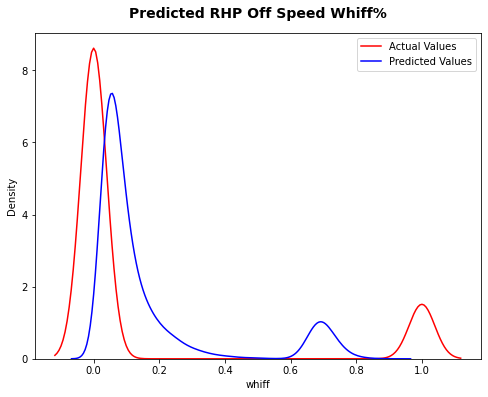

In [28]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted RHP Off Speed Whiff%', fontsize = 14, fontweight = 'bold', pad = 15);

### RHP Off Speed Stuff+ Table

In [29]:
rhp_os['xWhiff'] = pred * 100
rhp_os['n_pitches'] = 1
rhp_os['Stuff+'] = 100 * (rhp_os['xWhiff'] / rhp_os['xWhiff'].mean())
#rhp_os.head()

grouped_os_r = rhp_os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches'].sum()

avg_os_r = rhp_os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension', 'Stuff+'].mean()
osr_stuff = pd.merge(avg_os_r, grouped_os_r, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
osr_stuff = osr_stuff.loc[osr_stuff['n_pitches'] >= 100]
osr_stuff = osr_stuff.round(1)
osr_stuff.insert(3, 'n_pitches', osr_stuff.pop('n_pitches'))
osr_stuff.sort_values(by = 'Stuff+', ascending = False).head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,Stuff+
32,"Bautista, Félix",R,FS,256,88.5,7.5,6.8,0.9,7.0,6.4,168.6
390,"Stanek, Ryne",R,FS,205,88.6,12.3,3.9,0.4,6.4,6.1,162.6
251,"Leiter Jr., Mark",R,FS,237,84.2,6.4,4.5,1.2,5.8,6.6,157.0
309,"Neris, Hector",R,FS,305,85.1,10.7,-0.7,1.6,6.1,6.2,155.0
315,"Ohtani, Shohei",R,FS,310,89.3,5.5,2.5,2.1,6.1,6.9,154.4
474,"Woodruff, Brandon",R,CH,386,86.2,15.8,8.9,1.3,5.8,6.7,151.1
161,"Gausman, Kevin",R,FS,978,85.2,15.0,4.9,2.4,5.9,6.5,149.7
352,"Richards, Trevor",R,CH,429,84.1,16.2,6.2,2.4,6.2,6.4,148.3
198,"Hernández, Jonathan",R,CH,103,90.1,19.3,5.7,1.5,5.4,6.4,145.9
247,"Lange, Alex",R,CH,203,89.7,16.5,2.5,2.6,5.7,6.5,144.1


### RHP Off Speed Stuff+ Movement Plot

RHP Off-Speed Avg Stuff+: 100


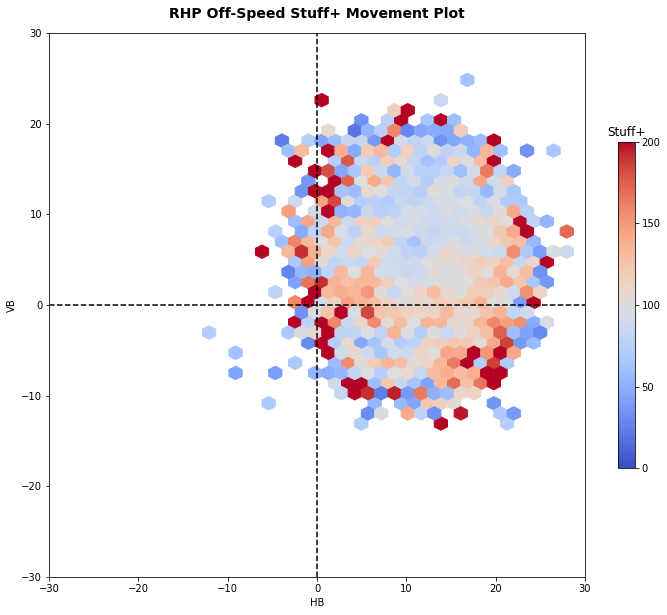

In [30]:
plt.figure(figsize = (12, 10))

plt.hexbin(rhp_os['pfx_x'], rhp_os['pfx_z'], C = rhp_os['Stuff+'], cmap = 'coolwarm', 
           mincnt = 0, gridsize = 30)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Off-Speed Avg Stuff+:', round(rhp_os['Stuff+'].mean()))

## Off Speed LHP
#### Changeup, Splitter

In [31]:
print('Baseline LHP Off Speed Whiff% Accuracy Score:', round(lhp_os.whiff.mean(), 2))

Baseline LHP Off Speed Whiff% Accuracy Score: 0.15


In [32]:
features_os_l = lhp_os.select_dtypes([np.number])
X = features_os_l.drop(columns = ['whiff'])
y = features_os_l['whiff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 1)

rf = RandomForestRegressor(n_estimators = 500, n_jobs = -1, random_state = 1).fit(X_train, y_train)

pred_os_l = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_os_l)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_l)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_l), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.052
Test RMSE: 0.366
Test MAE: 0.272 

R2 Score: 0.636
RMSE: 0.218
MAE: 0.144


- Average RHP Off Speed Run Value prediction error is .27 runs

### LHP Off Speed Actual & Predicted Values

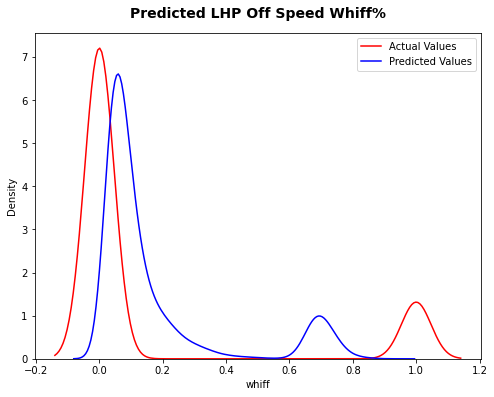

In [33]:
plt.figure(figsize = (8, 6))

ax = sns.distplot(y, hist = False, color = 'r', label = 'Actual Values')
sns.distplot(pred, hist = False, color = 'b', label = 'Predicted Values', ax = ax)
plt.legend()
plt.title('Predicted LHP Off Speed Whiff%', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Off Speed Stuff+ Table

In [34]:
lhp_os['xWhiff'] = pred * 100
lhp_os['n_pitches'] = 1
lhp_os['Stuff+'] = 100 * (lhp_os['xWhiff'] / lhp_os['xWhiff'].mean())
#lhp_os.head()

grouped_os_l = lhp_os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                              as_index = False)['n_pitches'].sum()

avg_os_l = lhp_os.groupby(['player_name', 'p_throws', 'pitch_type'], 
                          as_index = False)['velo', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 
                                            'release_extension', 'Stuff+'].mean()
osl_stuff = pd.merge(avg_os_l, grouped_os_l, how = 'left', on = ['player_name', 'p_throws', 'pitch_type'])
osl_stuff = osl_stuff.loc[osl_stuff['n_pitches'] >= 100]
osl_stuff = osl_stuff.round(1)
osl_stuff.insert(3, 'n_pitches', osl_stuff.pop('n_pitches'))
osl_stuff.sort_values(by = 'Stuff+', ascending = False).head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,Stuff+
101,"Moore, Matt",L,CH,196,85.0,-17.1,8.7,-1.4,6.4,6.2,161.7
140,"Skubal, Tarik",L,CH,285,83.6,-13.4,6.8,-2.1,6.3,6.2,154.0
86,"Luzardo, Jesús",L,CH,351,87.1,-15.5,8.4,-2.1,5.8,5.7,145.8
156,"Suter, Brent",L,CH,264,77.2,-10.0,11.0,-3.1,6.3,6.9,144.9
100,"Montgomery, Jordan",L,CH,603,82.3,-10.9,11.9,-1.8,6.4,6.8,140.6
143,"Smith, Caleb",L,CH,268,83.6,-13.6,15.4,-1.6,6.2,5.8,133.8
125,"Rodríguez, Joely",L,CH,322,87.8,-11.3,0.5,-3.8,5.4,6.3,133.2
7,"Anderson, Tyler",L,CH,803,79.0,-13.3,9.0,-1.8,6.2,6.1,132.2
121,"Ragans, Cole",L,CH,232,82.1,-16.2,14.2,-0.9,6.4,6.2,131.3
92,"McClanahan, Shane",L,CH,624,87.7,-16.0,10.5,-1.0,6.1,6.9,130.5


### LHP Off Speed Stuff+ Movement Plot

LHP Off-Speed Avg Stuff+: 100


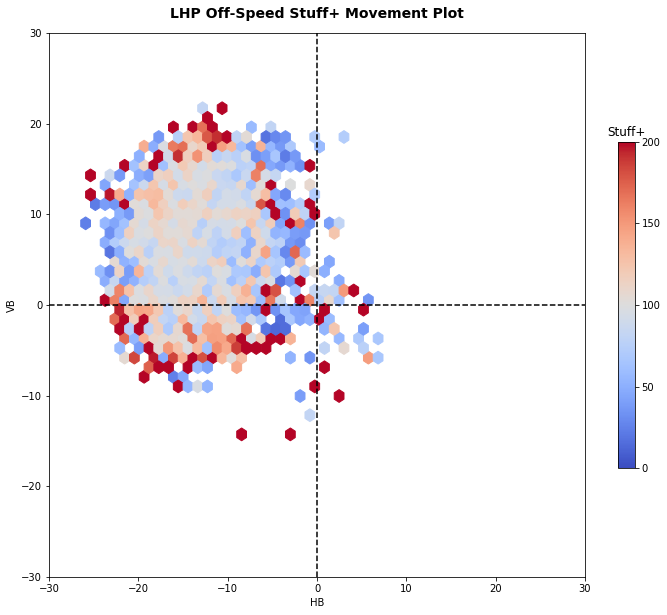

In [35]:
plt.figure(figsize = (12, 10))

plt.hexbin(lhp_os['pfx_x'], lhp_os['pfx_z'], C = lhp_os['Stuff+'], cmap = 'coolwarm', 
           mincnt = 0, gridsize = 30)
cb = plt.colorbar(ticks = [0, 50, 100, 150, 200], shrink = .6)
cb.ax.set_title('Stuff+'), plt.clim(0, 200)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed Stuff+ Movement Plot', fontsize = 14, fontweight = 'bold', pad = 15);
print('LHP Off-Speed Avg Stuff+:', round(lhp_os['Stuff+'].mean()))

## Save Grouped RV Tables to CSV

In [36]:
xrv_grouped = pd.concat([rhp_fb, lhp_fb, rhp_bb, lhp_bb, rhp_os, lhp_os], ignore_index = True)
xrv_grouped.fillna(0, inplace = True)
xrv_grouped.to_csv('../data/xwhiff_grouped.csv')

rv_table = pd.concat([fbr_stuff, fbl_stuff, bbr_stuff, bbl_stuff, osr_stuff, osl_stuff])
rv_table.to_csv('../data/stuff_table.csv')